[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial6.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial6.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 4: Synthesising & Interpreting Diverse Data Sources

**Week 2, Day 4, Future Climate: The Physical Basis**

**Content creators:** 

**Content reviewers:** 

**Content editors:** 

**Production editors:** 

**Our 2024 Sponsors:** 

# Tutorial Objectives
In this tutorial, we will synthesize scientific knowledge from various sources and use this diverse information to validate and contextualize CMIP6 simulations. By the end of this tutorial, you will be able to
- Create a time series of global mean sea surface temperature from observations, models, and proxy data;
- Use this data to validate & contextualize climate models, and to provide a holistic picture of Earth's past and future climate evolution.
[ADD/UPDATE]

# Setup

    



In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null


In [2]:
# imports
import time

tic = time.time()

import intake
# import intake_esm   #AKH
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree   
from xmip.postprocessing import _parse_metric

In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline

In [4]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uninformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)

def atlantic_mean(ds: xr.Dataset) -> xr.Dataset:
    """Atlantic zonal average, weighted by the cell area"""
    return ds.where(ds.basin==2).weighted(ds.areacello.fillna(0)).mean(["x",], keep_attrs=True)
def pacific_mean(ds: xr.Dataset) -> xr.Dataset:
    """Atlantic zonal average, weighted by the cell area"""
    return ds.where(ds.basin==3).weighted(ds.areacello.fillna(0)).mean(["x",], keep_attrs=True)


# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out

def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim="time")

In [5]:
# @title Video 1: Historical Context for Future Projections

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'lodJMDN6lbg'), ('Bilibili', 'BV1Bu41157mn')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [6]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "b4fsp"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: Reproduce Global SST for Historical and Future Scenario Experiments

We are now going to reproduce the plot you created in Tutorial 4, which showed the likely range of CMIP6 simulated global mean sea surface temperature for historical and future scenario (*SSP1-2.6* and *SSP5-8.5*) experiments from a *multi-model ensemble*. However, now we will add some an additional  dataset called *HadISST* which is an observational dataset spanning back to the 1870. Later in the tutorial, we will also include the paleo data you saw in the previous mini-lecture.


## Section 1.1: Load CMIP6 SST Data from Several Models using `xarray`

Let's load the five different CMIP6 models again for the three CMIP6 experiments.



In [7]:
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# there are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ["IPSL-CM6A-LR", "GFDL-ESM4", "ACCESS-CM2", "MPI-ESM1-2-LR", "TaiESM1"]
experiment_ids = ["historical", "ssp126", "ssp585"]

In [8]:
## TEMPERATURE and Oxygen DATA
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id=["tos", "o2"],
    member_id="r1i1p1f1",
    table_id="Omon",
    grid_label="gn",
    experiment_id=experiment_ids,
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)



# Get area metrics
cat_area = col.search(
    source_id=source_ids,
    variable_id="areacello",  # for the coding exercise, ellipses will go after the equals on this line
    member_id="r1i1p1f1",
    table_id="Ofx",  # for the coding exercise, ellipses will go after the equals on this line
    grid_label="gn",
    experiment_id=[
        "historical"
    ],  # for the coding exercise, ellipses will go after the equals on this line
    require_all_on=["source_id"],
)

cat_area.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)

    
# Get basin mask metrics   
cat_basin = col.search(
    source_id=source_ids,
    variable_id="basin",
    member_id="r1i1p1f1",
    table_id="Ofx",  # for the coding exercise, ellipsis' will go after the equals on this line
    grid_label="gn",
    experiment_id=[
        "historical"
    ],  # for the coding exercise, ellipsis' will go after the equals on this line
    require_all_on=["source_id"],
)
cat_basin.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_basin = cat_basin.to_datatree(**kwargs)    
    
    
dt_with_area_basin = DataTree()

for model, subtree in dt.items():
    metric = dt_basin[model]["historical"].ds["basin"]
    dt_with_area_basin[model] = subtree.map_over_subtree(_parse_metric, metric)
    

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

dt_gm_anomaly = datatree_anomaly(dt_gm)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/Users/brodiepearson/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/xmip/preprocessing.py:229: UserWarning: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/Users/brodiepearson/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/xmip/preprocessing.py:229: UserWarning: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/Users/brodiepearson/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/xmip/preprocessing.py:229: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [9]:
## OXYGEN DATA
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id="o2",
    member_id="r1i1p1f1",
    table_id="Omon",
    grid_label="gn",
    experiment_id=experiment_ids,
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_o2 = cat.to_datatree(**kwargs)


cat_basin = col.search(
    source_id=source_ids,
    variable_id="basin",
    member_id="r1i1p1f1",
    table_id="Ofx",  # for the coding exercise, ellipsis' will go after the equals on this line
    grid_label="gn",
    experiment_id=[
        "historical"
    ],  # for the coding exercise, ellipsis' will go after the equals on this line
    require_all_on=["source_id"],
)
cat_basin.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_basin = cat_basin.to_datatree(**kwargs)

# add 'area' and 'basin' as coords within main o2 datatree
dt_with_area = DataTree()
dt_with_area_basin = DataTree()

for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    mask = dt[model]["historical"].ds["o2"].isel(time=0)*0+1
    metric2 = (dt_basin[model]["historical"].ds["basin"]*mask).rename('basin')
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)
    dt_with_area_basin[model] = subtree.map_over_subtree(_parse_metric, metric).map_over_subtree(_parse_metric, metric2)

# # average every dataset in the tree globally -- option for 2D data, or volume mean, but not with the same fx
dt_gm = dt_with_area.map_over_subtree(global_mean)
dt_gm_anomaly = datatree_anomaly(dt_gm)

dt_atlm = dt_with_area_basin.map_over_subtree(atlantic_mean)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/Users/brodiepearson/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/xmip/preprocessing.py:229: UserWarning: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/Users/brodiepearson/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/xmip/preprocessing.py:229: UserWarning: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/Users/brodiepearson/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/xmip/preprocessing.py:229: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


### Example 0, mean O2 in Atlantic (SSP585 - historical)

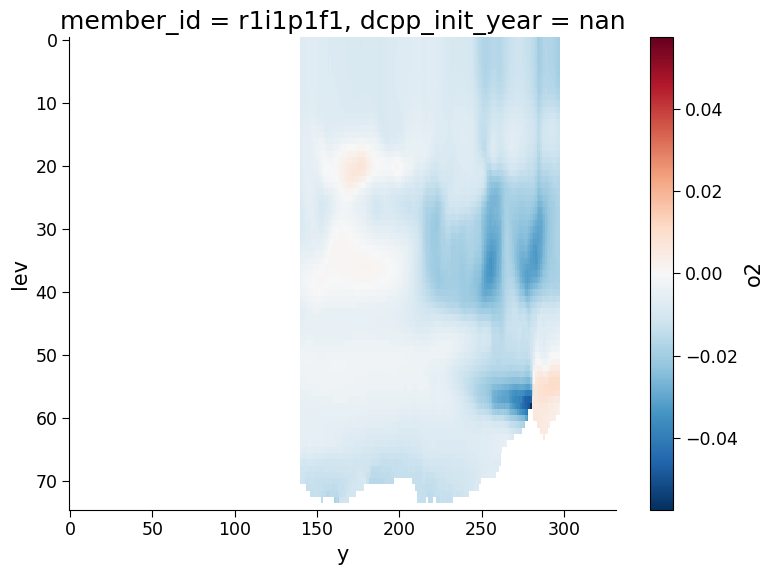

In [10]:
(dt_atlm['IPSL-CM6A-LR']["ssp585"].o2.mean('time')[0,0,:] - dt_atlm['IPSL-CM6A-LR']["historical"].o2.mean('time')[0,0,:]).plot(yincrease = False)

#### Here, would want comparison figure. If possible, load obs. data. Otherwise, just show figure, as they did for paleo-SST estimates below.


### Coding Exercise 1.1

Complete the following code to:


1.  Calculate a time series of the global mean sea surface temperature (GMSST) from the HadISST dataset
2.  Subtract a base period from the HadISST GMSST time series. Use the same base period as the CMIP6 timeseries you are comparing against.

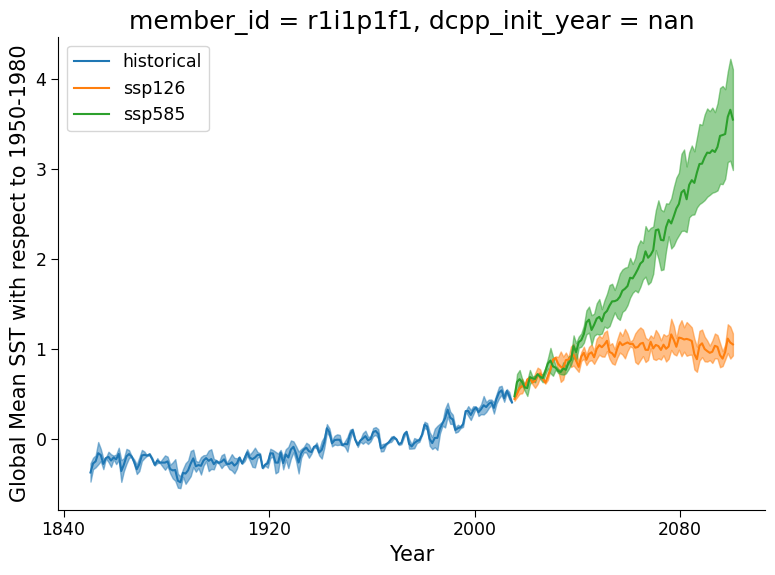

In [11]:
fig, ax = plt.subplots()
for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = (
            dt_gm_anomaly[model][experiment]
            .ds.tos.coarsen(time=12)
            .mean()
            .assign_coords(source_id=model)
            .load()
        )
        datasets.append(
            annual_sst.sel(time=slice(None, "2100")).load()
        )  # the french model has a long running member for ssp 126 (we could change the model to keep this clean)
    da = xr.concat(datasets, dim="source_id", join="override").squeeze()
    da.mean("source_id").plot(color=color, label=experiment, ax=ax)
    x = da.time.data
    da_lower = da.squeeze().quantile(0.17, dim="source_id")
    da_upper = da.squeeze().quantile(0.83, dim="source_id")
    ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)

# but now add observations (https://pangeo-forge.org/dashboard/feedstock/43)
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr"
ds_obs = xr.open_dataset(store, engine="zarr", chunks={}).convert_calendar(
    "standard", use_cftime=True
)
# mask missing values
ds_obs = ds_obs.where(ds_obs > -1000)
weights = np.cos(
    np.deg2rad(ds_obs.latitude)
)  # In a regular lon/lat grid, area is ~cos(latitude)
# calculate weighted global mean for observations
sst_obs_gm = ...
# calculate anomaly for observations
sst_obs_gm_anomaly = ...

# plot observations
# Uncomment below once you fill in the above ellipses
# sst_obs_gm_anomaly.coarsen(time=12, boundary="trim").mean().plot(
#     color="0.3", label="Observations", ax=ax
# )
ax.set_ylabel("Global Mean SST with respect to 1950-1980")
ax.set_xlabel("Year")
ax.legend()

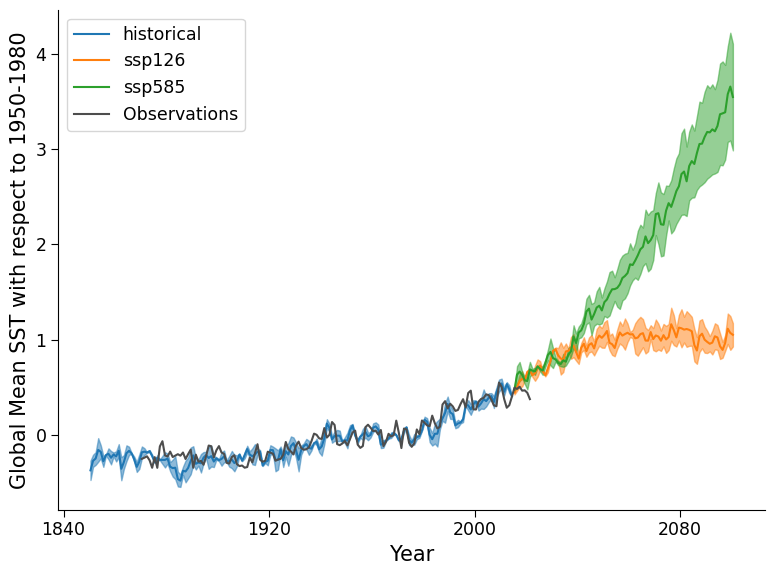

In [12]:
# to_remove solution
fig, ax = plt.subplots()
for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = (
            dt_gm_anomaly[model][experiment]
            .ds.tos.coarsen(time=12)
            .mean()
            .assign_coords(source_id=model)
            .load()
        )
        datasets.append(
            annual_sst.sel(time=slice(None, "2100")).load()
        )  # the french model has a long running member for ssp 126 (we could change the model to keep this clean)
    da = xr.concat(datasets, dim="source_id", join="override").squeeze()
    da.mean("source_id").plot(color=color, label=experiment, ax=ax)
    x = da.time.data
    da_lower = da.squeeze().quantile(0.17, dim="source_id")
    da_upper = da.squeeze().quantile(0.83, dim="source_id")
    ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)


# but now add observations (https://pangeo-forge.org/dashboard/feedstock/43)
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr"
ds_obs = xr.open_dataset(store, engine="zarr", chunks={}).convert_calendar(
    "standard", use_cftime=True
)
# mask missing values
ds_obs = ds_obs.where(ds_obs > -1000)
weights = np.cos(
    np.deg2rad(ds_obs.latitude)
)  # In a regular lon/lat grid, area is proportional to cos(latitude)
# calculate weighted global mean for observations
sst_obs_gm = ds_obs.sst.weighted(weights).mean(["longitude", "latitude"])
# calculate anomaly for observations
sst_obs_gm_anomaly = sst_obs_gm - sst_obs_gm.sel(time=slice("1950", "1980")).mean()

# plot observations
# Uncomment below once you fill in the above ellipsis'
# sst_obs_gm_anomaly.coarsen(time=12, boundary="trim").mean().plot(
#     color="0.3", label="Observations", ax=ax
# )
sst_obs_gm_anomaly.coarsen(time=12, boundary="trim").mean().plot(
    color="0.3", label="Observations", ax=ax
)
ax.set_ylabel("Global Mean SST with respect to 1950-1980")
ax.set_xlabel("Year")
ax.legend()

## Variant - oxygen

In [13]:
dt_gm_anomaly['IPSL-CM6A-LR']["historical"]

DataTree('historical', parent="IPSL-CM6A-LR")
    Dimensions:         (time: 1980, lev: 75, member_id: 1, dcpp_init_year: 1)
    Coordinates:
      * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
      * lev             (lev) int64 0 1 2 3 4 5 6 7 8 ... 66 67 68 69 70 71 72 73 74
      * member_id       (member_id) object 'r1i1p1f1'
      * dcpp_init_year  (dcpp_init_year) float64 nan
    Data variables:
        o2              (member_id, dcpp_init_year, time, lev) float32 dask.array<chunksize=(1, 1, 4, 75), meta=np.ndarray>
        tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 252), meta=np.ndarray>

In [ ]:
#  solution
fig, ax = plt.subplots()
for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_o2 = (
            dt_gm_anomaly[model][experiment]
            .ds.o2.coarsen(time=12)
            .mean()
            .sel(lev=1, method='nearest')
            .assign_coords(source_id=model)
            .load()
        )
        datasets.append(
            annual_o2.sel(time=slice(None, "2100")).load()
        )  # the french model has a long running member for ssp 126 (we could change the model to keep this clean)
    da = xr.concat(datasets, dim="source_id", join="override").squeeze()
    da.mean("source_id").plot(color=color, label=experiment, ax=ax)
    x = da.time.data
    da_lower = da.squeeze().quantile(0.17, dim="source_id")
    da_upper = da.squeeze().quantile(0.83, dim="source_id")
    ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)


# # but now add observations ... CAN WE??? ASKED FOR HELP. 
# # code below is sst.

# ds_obs = xr.open_dataset(store, engine="zarr", chunks={}).convert_calendar(
#     "standard", use_cftime=True
# )
# # mask missing values
# ds_obs = ds_obs.where(ds_obs > -1000)
# weights = np.cos(
#     np.deg2rad(ds_obs.latitude)
# )  # In a regular lon/lat grid, area is ~cos(latitude)
# # calculate weighted global mean for observations
# sst_obs_gm = ds_obs.sst.weighted(weights).mean(["longitude", "latitude"])
# # calculate anomaly for observations
# sst_obs_gm_anomaly = sst_obs_gm - sst_obs_gm.sel(time=slice("1950", "1980")).mean()

# plot observations
# Uncomment below once you fill in the above ellipsis'
# sst_obs_gm_anomaly.coarsen(time=12, boundary="trim").mean().plot(
#     color="0.3", label="Observations", ax=ax
# )
# sst_obs_gm_anomaly.coarsen(time=12, boundary="trim").mean().plot(
#     color="0.3", label="Observations", ax=ax
# )

ax.set_ylabel("Global Mean (unweighted) O$_2$, difference from 1950-1980")
ax.set_xlabel("Year")
ax.legend()

### Questions 1.1 Climate Connection

Now that you have a modern and projected time series containing models and observations,
1. What context and/or validation of the simulations does this information provide?
2. What additional context/validation can you glean by also considering the paleo proxy information in the figure below? (This figure was shown in the last video)

Note the paleo periods on this figure represent the Mid-Pleiocene Warm Period (MPWP), the Last Inter-glacial (LIG) ad the Last Glacial Maximum (LGM)

![](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/img/W2D1_Tutorial_6_Insert_Figure.png?raw=true)

This image shows part of panel a) from Figure 9.3 from the IPCC AR6 WG1 report. This figure has the following caption: **Figure 9.3** | Sea surface temperature (SST) and its changes with time. (a) Time series of global mean SST anomaly relative to 1950–1980 climatology. Shown are paleoclimate reconstructions and PMIP models, observational reanalyses (HadISST) and multi-model means from the Coupled Model Intercomparison Project (CMIP) historical simulations, CMIP projections, and HighResMIP experiment. (b) Map of observed SST (1995–2014 climatology HadISST). (c) Historical SST changes from observations. (d) CMIP 2005–2100 SST change rate. (e) Bias of CMIP. (f) CMIP change rate. (g) 2005–2050 change rate for SSP5-8.5 for the CMIP ensemble. (h) Bias of HighResMIP (bottom left) over 1995–2014. (i) HighResMIP change rate for 1950–2014. (j) 2005–2050 change rate for SSP5-8.5 for the HighResMIP ensemble. No overlay indicates regions with high model agreement, where ≥80% of models agree on sign of change. Diagonal lines indicate regions with low model agreement, where <80% of models agree on sign of change (see Cross-Chapter Box Atlas.1 for more information). Further details on data sources and processing are available in the chapter data table (Table 9.SM.9).

In [ ]:
# to_remove explanation

"""
1. I will let you decide what you take away from synthesizing these figures and data!
""";

# Summary

In the final tutorial of the day, we learned about the importance of synthesizing CMIP6 model data (future projections and historical simulations), alongside modern climate and palroclimate observations. This synthesis provides validation of CMIP6 simulation data, and it provides historical context for recent and projected rapid changes in Earth's climate, as many of these changes are unprecedented in human-recored history.

In the upcoming tutorials, we will shift our focus towards the socio-economic aspects of future climate change. This exploration will take various forms, including the design of the Shared Socioeconomic Pathways (SSPs) we began using today. We'll contemplate the realism of different socio-economic future scenarios and examine their potential impacts on future climate forcings. Moreover, we'll delve into how a changing climate might affect society. As we proceed with the next tutorials, keep in mind the intricate connection between physical and socio-economic changes.

# Resources

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble.

For examples on how to access and analyze data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html)

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).

In [ ]:

from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml")

In [ ]:
cat.cat